In [1]:
%matplotlib inline  

In [2]:
import os
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
import matplotlib.ticker as ticker

import warnings
warnings.simplefilter("ignore", UserWarning)

In [3]:
os.chdir("..")

In [4]:
from Prior_optimization.gpr import GPR
from Prior_optimization import mean_functions, kernels
from Networks.factorized_gaussian_reparam_mlp import FactorizedGaussianMLPReparameterization
from Networks.mlp_masked import MLPMasked
from Samplers.likelihoods import LikCategorical
from Prior_optimization.priors import OptimGaussianPrior
from Utilities.rand_generators import ClassificationGenerator
from Utilities import util
from Networks.classification_net_masked import ClassificationNetMasked
from Prior_optimization.optimisation_mapper import PriorOptimisationMapper

In [5]:
util.set_seed(123)

In [6]:
# setting device on GPU if available, else CPU
n_gpu = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device} \n')

#Additional Info when using cuda
if device.type == 'cuda':
    n_gpu += torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('Number of available GPUs:', str(n_gpu))

Using device: cuda 

NVIDIA A100-SXM4-80GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Number of available GPUs: 1


# 1. Load `Banana` dataset

In [7]:
DATA_DIR = "./data/banana"
OUT_DIR = "./exp/banana"

In [8]:
# Load banana dataset
X = np.loadtxt(os.path.join(
    DATA_DIR, "banana_X_train"), delimiter=",").astype(np.float32)
y = np.loadtxt(os.path.join(
    DATA_DIR, "banana_Y_train"), delimiter=",").reshape([-1]).astype(np.int64)

In [9]:
# Setup directories
ckpt_dir = os.path.join(OUT_DIR, "ckpts")
figs_dir = os.path.join(OUT_DIR, "figs")
util.ensure_dir(ckpt_dir)
util.ensure_dir(figs_dir)

# 2. Configure hyper-parameters

Configure the neural network architecture. In this experiment, we use a 2-hidden layer MLP with tanh activation function. The number of hidden units at each layer is 100.

In [10]:
input_dim = 2
output_dim = 2
hidden_dims = [100] * 2
activation_fn = "tanh"

Configure the hyper-parameters of the prior optimization.  

In [11]:
# Configurations for the prior optimization
D = 3
mapper_batch_size = 256
prior_opt_configurations = {
    "n_data": mapper_batch_size,                            # The batch size 
    "num_iters": 6000,                                      # The number of iterations of the prior optimization
    "output_dim": 1,                                        # The dimension of the output
    "lambd": (torch.tensor([0.5, 1.5])/D).to(device),       # The regularization parameters for the layers
    "n_samples": 128,                                       # The number of function samples
    "lr": 1e-1,                                             # The learning rate for the optimizer
    "print_every": 100,                                     # After how many epochs a evaluation should be printed
    "save_ckpt_every":500,                                  # After how many epochs a checkpoint should be saved
    "shift": 1,                                             # The shift of the schedule for the regularization of the loss
    "scale": 12                                             # The scale of the schedule for the regularization of the loss
}

Setup of the values of the lengthsclaes and variances

In [12]:
variances = [1, 32]
lengthscales = [1, 4, 16]

Configure the hyper-parameters for the SGHMC sampler.  

In [13]:
sampling_configs = {
    "batch_size": 32,                 # Mini-batch size
    "num_samples": 40,                # Total number of samples for each chain 
    "n_discarded": 10,                # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 200,         # Number of burn-in steps
    "keep_every": 200,                # Thinning interval
    "lr": 1e-2,                       # Step size
    "num_chains": 4,                  # Number of chains
    "mdecay": 1e-2,                   # Momentum coefficient
    "print_every_n_samples": 5
}

# 3. Optimize the prior

In [14]:
masks_list = []
for variance in variances:
    for lengthscale in lengthscales:
        print("----" * 20)
        print("Lengthscale: {}; Variance: {}".format(lengthscale, variance))

        # Initialize data loader for the mapper
        data_loader = data_utils.DataLoader(
                            data_utils.TensorDataset(torch.from_numpy(X),
                                                     torch.from_numpy(y)),
                            batch_size=mapper_batch_size, shuffle=True)
        
        # Setup the measurement set generator
        # We draw measurement points from the training data
        rand_generator = ClassificationGenerator(data_loader)

        # Specify the target GP prior
        X_, y_ = rand_generator.get(return_label=True)
        # BEFORE RBF
        kernel = kernels.Exponential(
            input_dim,
            lengthscales=torch.tensor([lengthscale], dtype=torch.double, device = device),
            variance=torch.tensor([variance], dtype=torch.double, device = device))

        # Initialize tunable MLP prior
        opt_bnn_sparse = FactorizedGaussianMLPReparameterization(input_dim=2, output_dim=1, D = D, activation_fn=activation_fn, 
            hidden_dims=hidden_dims, device = device)
        opt_bnn_sparse = opt_bnn_sparse.to(device)
        
        # Initialize the mapper
        saved_dir = os.path.join(OUT_DIR, "len_{}_var_{}".format(
            lengthscale, variance))
        if not os.path.isfile(saved_dir):
            os.makedirs(saved_dir, exist_ok=True)
        mapper = PriorOptimisationMapper(out_dir=saved_dir, device=device, kernel = kernel).to(device)
        
        # Start optimization
        print("Start optimizing prior")
        p_hist, loss_hist = mapper.optimize(opt_bnn_sparse, rand_generator,**prior_opt_configurations)
        path = os.path.join(saved_dir, "loss_values.log")
        if not os.path.isfile(saved_dir):
            os.makedirs(saved_dir, exist_ok=True)
        np.savetxt(path, loss_hist, fmt='%.6e')
        path = os.path.join(saved_dir, "pruned_values.log")
        if not os.path.isfile(saved_dir):
            os.makedirs(saved_dir, exist_ok=True)
        np.savetxt(path, p_hist, fmt='%.6e')
        print("----" * 20)
        masks_list.append(opt_bnn_sparse.get_det_masks())
        with open(os.path.join(saved_dir, "masks_list.pkl"), "wb") as f:
            pickle.dump(masks_list, f)

--------------------------------------------------------------------------------
Lengthscale: 1; Variance: 1
Start optimizing prior
>>> Iteration #   1: Difference from GP 15205.4520 Number of pruned stochastic weights: 2
>>> Iteration # 100: Difference from GP 24746.1083 Number of pruned stochastic weights: 17
>>> Iteration # 200: Difference from GP 14892.9508 Number of pruned stochastic weights: 18
>>> Iteration # 300: Difference from GP 14753.2062 Number of pruned stochastic weights: 19
>>> Iteration # 400: Difference from GP 15221.7994 Number of pruned stochastic weights: 19
>>> Iteration # 500: Difference from GP 14994.6689 Number of pruned stochastic weights: 19
>>> Iteration # 600: Difference from GP 14886.1683 Number of pruned stochastic weights: 19
>>> Iteration # 700: Difference from GP 15493.5428 Number of pruned stochastic weights: 20
>>> Iteration # 800: Difference from GP 14908.6269 Number of pruned stochastic weights: 21
>>> Iteration # 900: Difference from GP 14733.2849

## 3.1 Visulaize Progression of the Prior Optimization

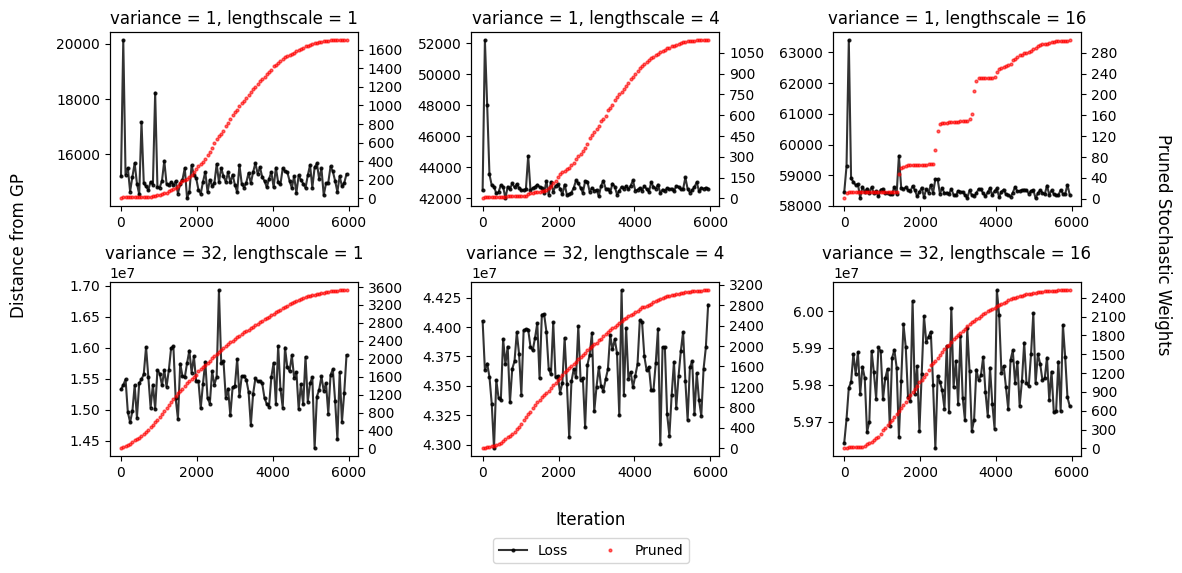

In [15]:
indices = np.arange(prior_opt_configurations["num_iters"])[::60]
fig, axs = plt.subplots(2, 3, figsize=(11, 5), sharex=False, dpi=100)

# For collecting legend handles/labels
all_handles = []
all_labels = []

for i, variance in enumerate(variances):
    for j, lengthscale in enumerate(lengthscales):
        sdist_file = os.path.join(OUT_DIR, f"len_{lengthscale}_var_{variance}", "loss_values.log")
        sdist_vals = np.loadtxt(sdist_file)
        pruned_file = os.path.join(OUT_DIR, f"len_{lengthscale}_var_{variance}", "pruned_values.log")
        pruned_vals = np.loadtxt(pruned_file)

        # Plot loss on primary axis
        h1, = axs[i, j].plot(indices, sdist_vals[indices], "-ok", ms=2, alpha=0.8, label="Loss")
        axs[i, j].set_title(rf"variance = {variance}, lengthscale = {lengthscale}")

        # Plot pruned weights on secondary y-axis
        ax2 = axs[i, j].twinx()
        h2, = ax2.plot(indices, pruned_vals[indices], "ro", ms=2, alpha=0.6, label="Pruned")
        ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

        if i == 0 and j == 0:  # Only collect once (or use a set to avoid duplicates)
            all_handles.extend([h1, h2])
            all_labels.extend(["Loss", "Pruned"])

# Shared axis labels
fig.text(0.5, -0.05, "Iteration", ha="center", va="center", fontsize=12)
fig.text(-0.02, 0.5, "Distance from GP", ha="center", va="center", rotation=90, fontsize=12)
fig.text(1.02, 0.5, "Pruned Stochastic Weights", ha="center", va="center", rotation=270, fontsize=12)

# Add legend outside the figure (bottom center)
fig.legend(all_handles, all_labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.15))

plt.tight_layout()
plt.show()

# 4. Sample from posterior using SGHMC sampler

In [14]:
index = 0
for variance in variances:
    for lengthscale in lengthscales:
        # Load the mask
        saved_dir = os.path.join(OUT_DIR, "len_{}_var_{}".format(
            lengthscale, variance))
        with open(os.path.join(saved_dir, "masks_list.pkl"), "rb") as f:
            masks_list = pickle.load(f)
        print("----" * 20)
        print("Lengthscale: {}; Variance: {}".format(lengthscale, variance))
        
        data_loader = data_utils.DataLoader(
                    data_utils.TensorDataset(torch.from_numpy(X), torch.from_numpy(y)),
                    batch_size=sampling_configs["batch_size"], shuffle=True)
        weights_mask , bias_mask = masks_list[index]
        index+=1
        # Setup the likelihood
        net = MLPMasked(input_dim, output_dim, hidden_dims, activation_fn, weight_masks=weights_mask, bias_masks= bias_mask,
                task="classification", D= D, device = device)
        likelihood = LikCategorical()
        # Load the optimized prior
        ckpt_path = os.path.join(saved_dir, "ckpts", "it-{}.ckpt".format(prior_opt_configurations["num_iters"]))
        print("Loading prior: {}".format(ckpt_path))
        prior = OptimGaussianPrior(ckpt_path)
        
        # Initialize the Bayesian net
        samples_dir = os.path.join(saved_dir, "samples")
        util.ensure_dir(samples_dir)
        bayes_net = ClassificationNetMasked(net, likelihood, prior, saved_dir, n_gpu=n_gpu)
        
        # Start sampling using SGHMC sampler
        bayes_net.sample_multi_chains(data_loader=data_loader, **sampling_configs)
        mean_preds, preds = bayes_net.evaluate(data_loader, True, True)

        # Make predictions using the posterior
        preds = []
        pred_means = []
        targets = []
        with torch.no_grad():
            for i, (data, target) in enumerate(data_loader):
                pred_mean, pred = bayes_net.predict(
                    data, return_individual_predictions=True,
                    num_samples=40)

                pred_means.append(pred_mean)
                preds.append(pred)
                targets.append(target)

        pred_means = torch.cat(pred_means, dim=0).cpu().numpy()
        preds = torch.cat(preds, dim=1).cpu().numpy()
        targets = torch.cat(targets, dim=0).cpu().numpy()
        x_grid = np.linspace(-3, 3, 40)
        xx, yy = np.meshgrid(x_grid, x_grid)
        Xplot = np.vstack((xx.flatten(), yy.flatten())).T

        p, _ = bayes_net.predict(torch.from_numpy(Xplot).float(), True, True)
        p = p.cpu().numpy()
        
        # Save the predictions to file
        data = { "xx": xx, "yy": yy, "X": X, "y": y, "p": p}
        with open(os.path.join(saved_dir, "preds.pickle"), 'wb') as f:
            pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
        
        print("----" * 20)

--------------------------------------------------------------------------------
Lengthscale: 1; Variance: 1
Loading prior: ./exp/banana/len_1_var_1/ckpts/it-6000.ckpt
Chain: 1
Samples #     5 : NLL = 0.04263 Acc = 1.0000  Pruned weights: 39
Samples #    10 : NLL = 0.12727 Acc = 0.9062  Pruned weights: 56
Samples #    15 : NLL = 0.07755 Acc = 1.0000  Pruned weights: 83
Samples #    20 : NLL = 0.01953 Acc = 1.0000  Pruned weights: 112
Samples #    25 : NLL = 0.10818 Acc = 0.9688  Pruned weights: 137
Samples #    30 : NLL = 0.13164 Acc = 0.9688  Pruned weights: 169
Chain: 2
Samples #    35 : NLL = 0.04200 Acc = 1.0000  Pruned weights: 310
Samples #    40 : NLL = 0.11485 Acc = 0.9375  Pruned weights: 331
Samples #    45 : NLL = 0.04223 Acc = 1.0000  Pruned weights: 360
Samples #    50 : NLL = 0.02535 Acc = 1.0000  Pruned weights: 383
Samples #    55 : NLL = 0.06487 Acc = 0.9688  Pruned weights: 402
Samples #    60 : NLL = 0.11252 Acc = 0.9375  Pruned weights: 426
Chain: 3
Samples #    65 

120it [00:02, 42.07it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 4; Variance: 1
Loading prior: ./exp/banana/len_4_var_1/ckpts/it-6000.ckpt
Chain: 1
Samples #     5 : NLL = 0.05871 Acc = 1.0000  Pruned weights: 17
Samples #    10 : NLL = 0.08056 Acc = 0.9688  Pruned weights: 28
Samples #    15 : NLL = 0.05983 Acc = 1.0000  Pruned weights: 45
Samples #    20 : NLL = 0.11759 Acc = 1.0000  Pruned weights: 56
Samples #    25 : NLL = 0.11979 Acc = 0.9688  Pruned weights: 68
Samples #    30 : NLL = 0.03879 Acc = 1.0000  Pruned weights: 95
Chain: 2
Samples #    35 : NLL = 0.06140 Acc = 1.0000  Pruned weights: 231
Samples #    40 : NLL = 0.09058 Acc = 0.9688  Pruned weights: 244
Samples #    45 : NLL = 0.08600 Acc = 0.9688  Pruned weights: 251
Samples #    50 : NLL = 0.04891 Acc = 1.0000  Pruned weights: 270
Samples #    55 : NLL = 0.03695 Acc = 1.0000  Pruned weights: 280
Samples #    

120it [00:02, 42.08it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 16; Variance: 1
Loading prior: ./exp/banana/len_16_var_1/ckpts/it-6000.ckpt
Chain: 1
Samples #     5 : NLL = 0.03161 Acc = 1.0000  Pruned weights: 2
Samples #    10 : NLL = 0.17990 Acc = 0.9062  Pruned weights: 3
Samples #    15 : NLL = 0.13421 Acc = 0.9062  Pruned weights: 11
Samples #    20 : NLL = 0.07911 Acc = 1.0000  Pruned weights: 16
Samples #    25 : NLL = 0.11165 Acc = 0.9375  Pruned weights: 23
Samples #    30 : NLL = 0.10882 Acc = 0.9688  Pruned weights: 28
Chain: 2
Samples #    35 : NLL = 0.07210 Acc = 0.9688  Pruned weights: 60
Samples #    40 : NLL = 0.11476 Acc = 0.9062  Pruned weights: 68
Samples #    45 : NLL = 0.06482 Acc = 1.0000  Pruned weights: 76
Samples #    50 : NLL = 0.07416 Acc = 1.0000  Pruned weights: 83
Samples #    55 : NLL = 0.08756 Acc = 0.9688  Pruned weights: 88
Samples #    60 : 

120it [00:02, 42.01it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 1; Variance: 32
Loading prior: ./exp/banana/len_1_var_32/ckpts/it-6000.ckpt
Chain: 1
Samples #     5 : NLL = 0.03456 Acc = 1.0000  Pruned weights: 39
Samples #    10 : NLL = 0.04178 Acc = 1.0000  Pruned weights: 66
Samples #    15 : NLL = 0.10381 Acc = 0.9688  Pruned weights: 108
Samples #    20 : NLL = 0.06736 Acc = 1.0000  Pruned weights: 171
Samples #    25 : NLL = 0.05765 Acc = 1.0000  Pruned weights: 241
Samples #    30 : NLL = 0.02339 Acc = 1.0000  Pruned weights: 321
Chain: 2
Samples #    35 : NLL = 0.03072 Acc = 1.0000  Pruned weights: 757
Samples #    40 : NLL = 0.11063 Acc = 0.9688  Pruned weights: 801
Samples #    45 : NLL = 0.08818 Acc = 0.9688  Pruned weights: 850
Samples #    50 : NLL = 0.01838 Acc = 1.0000  Pruned weights: 894
Samples #    55 : NLL = 0.07416 Acc = 0.9688  Pruned weights: 943
Samples

120it [00:02, 41.95it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 4; Variance: 32
Loading prior: ./exp/banana/len_4_var_32/ckpts/it-6000.ckpt
Chain: 1
Samples #     5 : NLL = 0.03879 Acc = 1.0000  Pruned weights: 57
Samples #    10 : NLL = 0.05547 Acc = 1.0000  Pruned weights: 90
Samples #    15 : NLL = 0.03844 Acc = 1.0000  Pruned weights: 141
Samples #    20 : NLL = 0.04891 Acc = 1.0000  Pruned weights: 199
Samples #    25 : NLL = 0.07903 Acc = 0.9688  Pruned weights: 264
Samples #    30 : NLL = 0.02765 Acc = 1.0000  Pruned weights: 329
Chain: 2
Samples #    35 : NLL = 0.04339 Acc = 1.0000  Pruned weights: 597
Samples #    40 : NLL = 0.06269 Acc = 1.0000  Pruned weights: 640
Samples #    45 : NLL = 0.07704 Acc = 1.0000  Pruned weights: 674
Samples #    50 : NLL = 0.06618 Acc = 1.0000  Pruned weights: 719
Samples #    55 : NLL = 0.05484 Acc = 1.0000  Pruned weights: 759
Samples

120it [00:02, 42.35it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 16; Variance: 32
Loading prior: ./exp/banana/len_16_var_32/ckpts/it-6000.ckpt
Chain: 1
Samples #     5 : NLL = 0.06508 Acc = 1.0000  Pruned weights: 38
Samples #    10 : NLL = 0.03877 Acc = 1.0000  Pruned weights: 59
Samples #    15 : NLL = 0.05081 Acc = 1.0000  Pruned weights: 94
Samples #    20 : NLL = 0.10588 Acc = 0.9375  Pruned weights: 130
Samples #    25 : NLL = 0.05396 Acc = 1.0000  Pruned weights: 170
Samples #    30 : NLL = 0.14476 Acc = 0.9375  Pruned weights: 229
Chain: 2
Samples #    35 : NLL = 0.04415 Acc = 1.0000  Pruned weights: 509
Samples #    40 : NLL = 0.10583 Acc = 0.9375  Pruned weights: 544
Samples #    45 : NLL = 0.13391 Acc = 0.9375  Pruned weights: 566
Samples #    50 : NLL = 0.00965 Acc = 1.0000  Pruned weights: 593
Samples #    55 : NLL = 0.04987 Acc = 1.0000  Pruned weights: 616
Sample

120it [00:02, 42.20it/s]


--------------------------------------------------------------------------------


# 5. Visualize predictive posterior

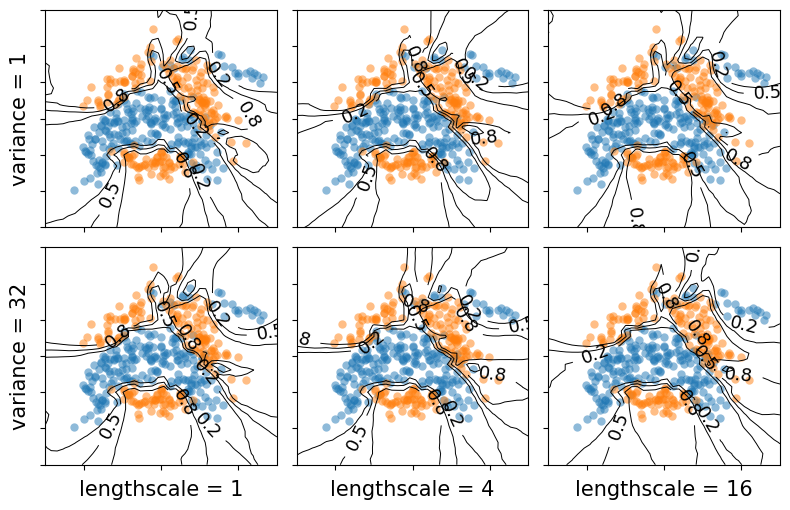

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=3, tight_layout=False,
                        figsize=(8, 5.2), sharex=True, sharey=True, dpi=100)

for i, variance in enumerate(variances):
    for j, lengthscale in enumerate(lengthscales):
        data_file = os.path.join(OUT_DIR, "len_{}_var_{}".format(lengthscale, variance),
                                  "preds.pickle")
        
        with open(data_file, "rb") as f:
            data = pickle.load(f)
        
        X = data['X']
        y = data['y']
        p = data['p']
        xx = data['xx']
        yy = data['yy']

        mask = y.reshape([-1, 1])[:, 0] == 1
        Xplot = np.vstack((xx.flatten(), yy.flatten())).T
        
        ax[i, j].plot(X[mask, 0], X[mask, 1], "oC0", mew=0, alpha=0.5, ms=6)
        ax[i, j].plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], "oC1", mew=0, alpha=0.5, ms=6)
        CS = ax[i, j].contour(
            xx,
            yy,
            p[:, 0].reshape(*xx.shape),
            [0.2, 0.5, 0.8],
            colors="k",
            linewidths=0.7,
            zorder=100,
        )
        ax[i, j].clabel(CS, inline=1, fontsize=13, fmt='%1.1f')
        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])
        
        if j == 0:
            ax[i, j].set_ylabel(r"variance = {}".format(variance), fontsize=15)
        if i == 1:
            ax[i, j].set_xlabel(r"lengthscale = {}".format(lengthscale), fontsize=15)
            
plt.tight_layout()
plt.show()